In [3]:
# import libraries 
import pandas as pd
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import skfuzzy as fuzz
import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F', '#697268', '#12355B', '#D7816A', '#c91e29', '#c33b43', 
               '#9DBF9E', '#cd5a61', '#343934', '#e8da6f','#64a0e0', '#913d27', 
               '#F46036', '#5386E4',  '#bea602', '#0a6682', '#215463']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [5]:
# import clean data set

# df_wind = pd.read_csv('../../../../data_analysis_and_preproc/intermediate/wind/df_wind.csv')

In [6]:
# df_wind = df_wind.iloc[:,1:]
# df_wind.head()

In [7]:
# df_wind["read_at"] = pd.to_datetime(df_wind["read_at"]).map(pd.Timestamp.timestamp)

In [8]:
# df_wind["read_at"] = df_wind["read_at"].astype("uint32")
# df_wind["read_at"]

In [9]:
# np.random.seed(1)

# asset = df_wind['asset_id'].unique()[0]

# length = len(df_wind[df_wind['asset_id'] == asset])

# subset_size = int(0.01*length)  # Adjust the percentage as needed

# # Group the DataFrame by the asset identifier column(s)
# grouped = df_wind.groupby('asset_id')

# # Initialize an empty list to store the sampled data
# subset_data = []

# # Iterate over each group, sample subset_size rows from each group, and append to subset_data
# for _, group_df in grouped:
#     sampled_group = group_df.sample(n=subset_size, replace=False)
#     subset_data.append(sampled_group)

# # Concatenate the sampled data from all groups into a single DataFrame
# df_subset = pd.concat(subset_data)

In [10]:
# df_subset.to_csv('df_subset.csv', index = False)

In [11]:
df_subset = pd.read_csv('df_subset.csv')

# Partition Clustering

## K-Means

In [12]:
X = df_subset.loc[:, 'wind_speed':'nacelle_temperature']
X = X.reset_index(drop=True)
X.head()

,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature
0,3.8,227.0,80.0,8.41,12.0,21.0
1,5.2,231.0,165.0,9.93,5.0,20.0
2,8.6,61.0,1013.0,16.26,7.0,12.0
3,3.4,245.0,45.0,7.44,7.0,21.0
4,7.0,271.0,571.0,14.35,0.0,12.0


since this methods are distance based, we should normalize the values

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled)

X_scaled.columns= X_scaled.columns.astype(str)

In [14]:
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df.head()

,PC1,PC2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956


In [15]:
pca_df.to_csv('pca_df.csv', index = False)

In [16]:
pca_df = pd.DataFrame(pca_result, columns=[1, 2])
pca_df.head()

,1,2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956


In [17]:
# Print explained variance ratio
print("Explained Variance Ratio:")
print(pca.explained_variance_ratio_)

# Print PCA components (loadings)
print("PCA Components (Loadings):")
print(pd.DataFrame(pca.components_))

Explained Variance Ratio:
[0.57643    0.20976798]
PCA Components (Loadings):
          0         1         2         3         4         5
0  0.493100 -0.026749  0.488803  0.477489 -0.335465 -0.420329
1  0.317188  0.111847  0.296439  0.296952  0.668948  0.513161


### Find the optimal k number by the elbow method

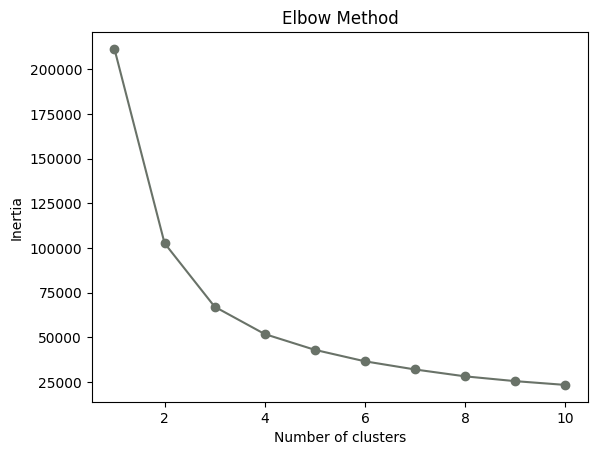

In [42]:
inertia = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pca_df)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,11), inertia, marker = 'o', c = '#697268')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

k = 4, because is where inertia starts decreasing in an almost linear rate

### Clusters

In [43]:
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(pca_df)

# Get cluster labels
cluster_labels = kmeans.labels_

In [44]:
with open('results/partitional/kmeans_model.pickle', 'wb') as f:
    pickle.dump(kmeans, f)

In [45]:
with open('results/partitional/kmeans_model.pickle', 'rb') as f:
    kmeans = pickle.load(f)

cluster_labels = kmeans.labels_

In [46]:
df_subset['cluster'] = cluster_labels

In [48]:
df_subset.to_csv('results/partitional/csv_labels_raw/kmeans.csv', index=False)

In [47]:
df_subset['cluster'].nunique()

4

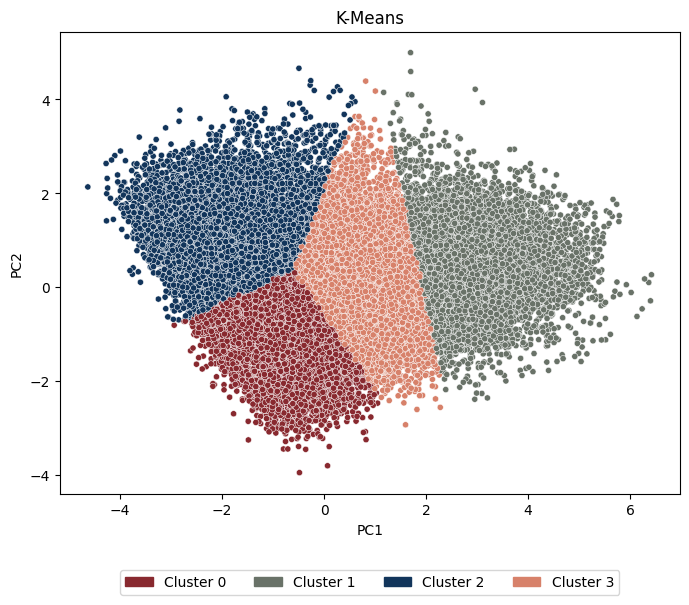

In [25]:
pca_df['cluster'] = df_subset['cluster']

n_clusters = len(pca_df['cluster'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x=1, y=2, hue='cluster', palette=pallete, s=20)
plt.title('K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [49]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,0
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,0
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,0
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,0
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,0


In [50]:
df_subset.to_csv('results/partitional/labels_most_common/k_means.csv', index = False)

In [51]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,0
1,12,1663674600,2.8,65.0,15.0,6.38,23.0,36.0,1,0
2,13,1623918000,2.4,-95.0,8.0,5.89,13.0,29.0,1,0
3,14,1674150600,16.5,-65.0,2056.0,18.00,5.0,13.0,1,0
4,15,1663676400,3.1,76.0,29.0,7.02,25.0,40.0,1,0


In [52]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70]
Cluster 1: [6, 7]
Cluster 2: [21, 42]
Cluster 3: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 40, 45, 53, 56, 69]


in this case, setting 4 clusters for the whole data set, results in having the assets divided in 4 clusters

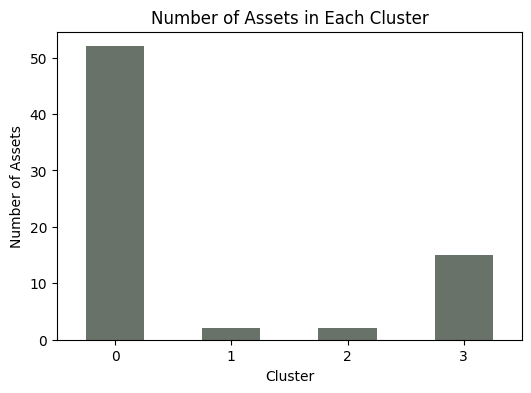

In [53]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [58]:
df_subset = df_subset.loc[:,:'farm']
df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1


In [57]:
pca_df = pca_df.loc[:,:2]
pca_df.head()

,1,2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956


## K-Medoids (clara)

In [61]:
def clara(unique_assets, X, num_samples, num_medoids):
    best_cost = float('inf')
    best_labels = None
    for i in range(num_samples):
        sample_indices = np.random.choice(unique_assets, size=num_medoids, replace=False)
        
        # Filter X to include only rows corresponding to selected assets
        X_filtered = pd.DataFrame(X)[pd.DataFrame(X)['asset_id'].isin(sample_indices)]

        # Randomly select one row for each asset
        sample = X_filtered.groupby('asset_id').apply(lambda x: x.sample(1)).reset_index(drop=True)

        kmedoids = KMedoids(n_clusters=3, metric='euclidean', init='k-medoids++', max_iter=300)
        kmedoids.fit(sample)
        if kmedoids.inertia_ < best_cost:
            best_cost = kmedoids.inertia_
            best_labels = kmedoids.labels_
        
        print(f'sample {i} of {num_samples}')
        
    cluster_labels = np.repeat(best_labels, len(df_subset) // len(best_labels) + 1)[:len(df_subset)]

    return cluster_labels

In [62]:
pca_df['asset_id'] = df_subset['asset_id']
pca_df.head()

,1,2,asset_id
0,-1.253143,-0.763049,11
1,-0.374977,-1.197599,11
2,1.976068,-0.386187,11
3,-1.228114,-1.370854,11
4,1.454437,-1.465956,11


In [63]:
num_medoids = 4

num_samples = 20

unique_assets = pca_df['asset_id'].unique()

# Run Clara algorithm
cluster_labels_sampled = clara(unique_assets, pca_df, num_samples, num_medoids)

print(len((cluster_labels_sampled)))

# Add cluster labels to original dataframe
pca_df['cluster'] = cluster_labels_sampled
df_subset['cluster'] = cluster_labels_sampled

sample 0 of 20
sample 1 of 20
sample 2 of 20
sample 3 of 20
sample 4 of 20
sample 5 of 20
sample 6 of 20
sample 7 of 20
sample 8 of 20
sample 9 of 20
sample 10 of 20
sample 11 of 20
sample 12 of 20
sample 13 of 20
sample 14 of 20
sample 15 of 20
sample 16 of 20
sample 17 of 20
sample 18 of 20
sample 19 of 20
44801


In [66]:
df_subset.to_csv('results/partitional/csv_labels_raw/clara.csv', index=False)

In [67]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,1


In [68]:
df_subset.to_csv('results/partitional/labels_most_common/k_medoids_clara.csv', index=False)

In [69]:
pca_df = pca_df.drop(columns='asset_id')

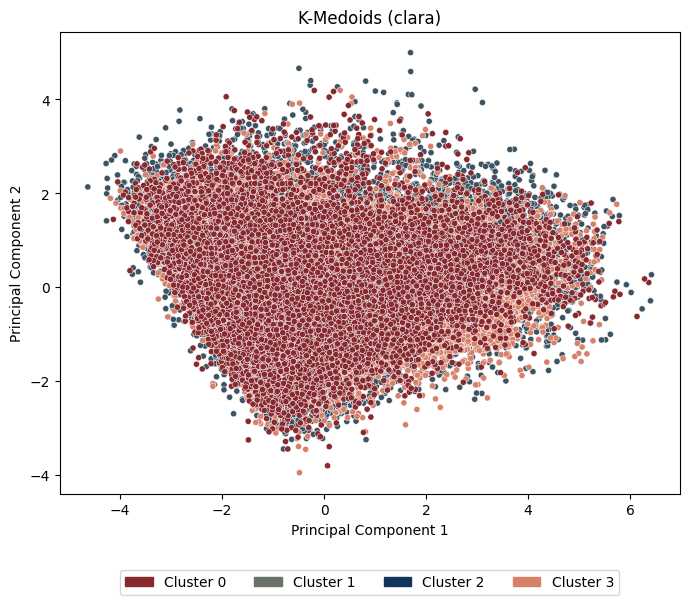

In [72]:
# Add 'cluster' column back to DataFrame
pca_df['cluster'] = df_subset['cluster']

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x=1, y=2, hue='cluster', palette=custom_cmap, s=20)
plt.title('K-Medoids (clara)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(cluster_labels)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [73]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,12,1663674600,2.8,65.0,15.0,6.38,23.0,36.0,1,1
2,13,1623918000,2.4,-95.0,8.0,5.89,13.0,29.0,1,1
3,14,1674150600,16.5,-65.0,2056.0,18.00,5.0,13.0,1,1
4,15,1663676400,3.1,76.0,29.0,7.02,25.0,40.0,1,1


In [74]:
assets_clusters = representative_points.groupby('cluster')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
Cluster 2: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


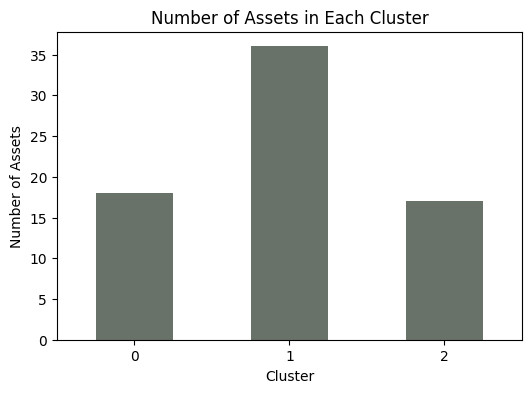

In [75]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [76]:
pca_df = pca_df.loc[:,:2]
df_subset = df_subset.loc[:,:'farm']

### Fuzzy C-Means

In [18]:
# Define parameters
num_clusters = 4
fuzziness = 2 

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    pca_df.T, num_clusters, fuzziness, error=0.005, maxiter=1000, init=None)

# Extract cluster centroids
cluster_centroids = cntr.T

# Extract cluster membership probabilities
cluster_membership = u.T

# Assign data points to clusters based on membership probabilities
assigned_clusters = np.argmax(cluster_membership, axis=1)

In [19]:
data = {
    "cntr": cntr,
    "u": u,
    "u0": u0,
    "d": d,
    "jm": jm,
    "p": p,
    "fpc": fpc
}

# Open the file in write binary mode
with open('results/partitional/fuzzy_c_means.pickle', "wb") as f:
    # Use pickle to dump the data dictionary into the file
    pickle.dump(data, f)

In [20]:
df_subset['cluster'] = assigned_clusters
pca_df['cluster'] = assigned_clusters

In [21]:
df_subset.to_csv('results/partitional/csv_labels_raw/fuzzy_c_means.csv', index = False)

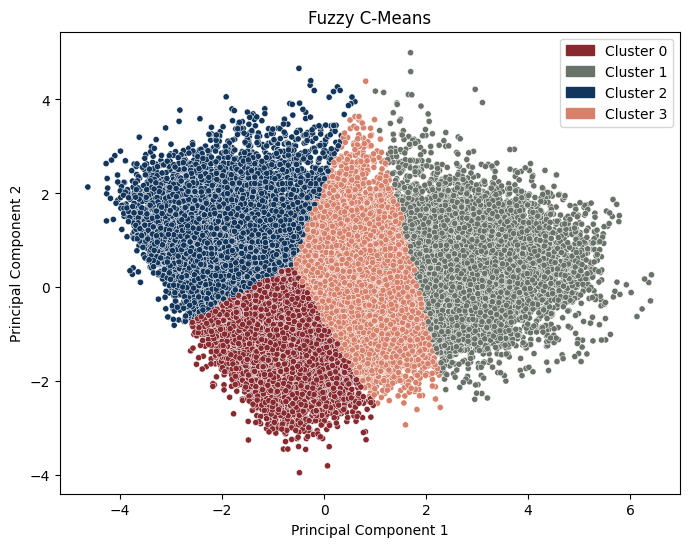

In [23]:
# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x=1, y=2, hue='cluster', palette=custom_cmap, s=20)
plt.title('Fuzzy C-Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(assigned_clusters)])
plt.show()

In [24]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

In [25]:
df_subset.to_csv('results/partitional/labels_most_common/fuzzy_c_means.csv', index = False)

In [26]:
# Group by asset_id and cluster, and select one representative point for each cluster
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster
0,11,1641199200,3.80,227.00,80.00,8.41,12.00,21.00,1,0
1,12,1663674600,2.80,65.00,15.00,6.38,23.00,36.00,1,3
2,13,1623918000,2.40,-95.00,8.00,5.89,13.00,29.00,1,0
3,14,1674150600,16.50,-65.00,2056.00,18.00,5.00,13.00,1,0
4,15,1663676400,3.10,76.00,29.00,7.02,25.00,40.00,1,0
...,...,...,...,...,...,...,...,...,...,...
66,414,1676895600,2.40,-252.00,5.00,5.45,15.00,21.00,4,0
67,415,1636346400,4.90,-285.00,173.00,10.16,8.00,15.00,4,0
68,510,1628030400,4.91,313.39,198.62,8.34,17.08,24.11,5,0
69,511,1621104600,8.52,244.07,1321.08,13.85,14.55,17.69,5,3


In [27]:
assets_clusters = df_subset.groupby('asset_id')['cluster'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [11, 13, 14, 15, 16, 31, 32, 33, 35, 36, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 54, 56, 58, 59, 111, 112, 113, 114, 116, 117, 310, 312, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 510, 512]
Cluster 1: [17, 18, 115]
Cluster 2: [34, 57]
Cluster 3: [12, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 37, 53, 55, 110, 210, 311, 511]


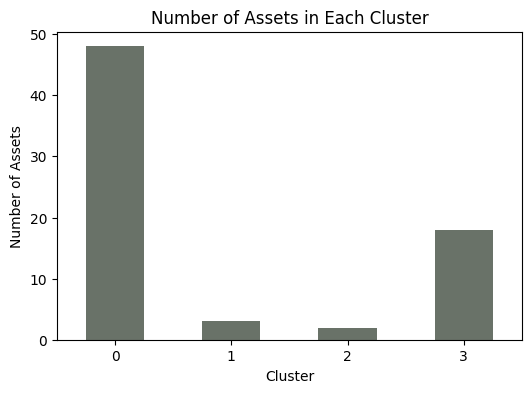

In [28]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()